# Analyse des transactions immobilières en France  
*Une approche par les caractéristiques du logement, le contexte géographique et la proximité aux gares SNCF*

## 1. Données et préparation

### 1.1 Chargement et nettoyage initial

In [53]:
# On effectue les importations basiques utiles
import pandas as pd
import numpy as np


# Chemin vers le fichier DVF (données des transactions immobilières)
FILE_PATH = "/home/onyxia/work/Projet-Python-2A-ENSAE/ValeursFoncieres-2025-S1.csv"

In [54]:
# --- 1ERE LECTURE DU FICHIER DVF ---

# On lit le fichier CSV avec pandas
df = pd.read_csv(
    FILE_PATH,        # chemin du fichier
    sep="|",           # les colonnes sont séparées par le caractère |
    dtype=str,         # on lit tout comme du texte pour éviter les erreurs de type
    decimal=",",       # les nombres utilisent une virgule comme séparateur décimal
    na_values=["", " "],  # les champs vides sont considérés comme des valeurs manquantes
    engine="python"    # moteur plus tolérant pour les fichiers DVF
)

print(df.head())

  Identifiant de document Reference document 1 Articles CGI 2 Articles CGI 3 Articles CGI 4 Articles CGI 5 Articles CGI No disposition Date mutation Nature mutation Valeur fonciere No voie B/T/Q Type de voie Code voie              Voie Code postal    Commune Code departement Code commune Prefixe de section Section No plan No Volume 1er lot Surface Carrez du 1er lot 2eme lot Surface Carrez du 2eme lot 3eme lot Surface Carrez du 3eme lot 4eme lot Surface Carrez du 4eme lot 5eme lot Surface Carrez du 5eme lot Nombre de lots Code type local  Type local Identifiant local Surface reelle bati Nombre pieces principales Nature culture Nature culture speciale Surface terrain
0                     NaN                NaN            NaN            NaN            NaN            NaN            NaN         000001    07/01/2025           Vente       468000,00     NaN   NaN          NaN      B078            FARGES        1550     FARGES               01          158                NaN       B     815   

In [55]:
# --- NETTOYAGE DE BASE DES VARIABLES ---

# Conversion de la date de mutation en format jour/mois/année
df["Date mutation"] = pd.to_datetime(
    df["Date mutation"],
    format="%d/%m/%Y",
    errors="coerce"    # les dates invalides deviennent NaT
)

# Conversion de la valeur foncière en nombre : on remplace la virgule par un point puis on convertit en float
df["Valeur fonciere"] = (
    df["Valeur fonciere"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Conversion de la surface du terrain en nombre
# Les valeurs non valides deviennent NaN
df["Surface terrain"] = pd.to_numeric(
    df["Surface terrain"],
    errors="coerce"
)

# Conversion de la surface réelle bâtie en nombre
df["Surface reelle bati"] = pd.to_numeric(
    df["Surface reelle bati"],
    errors="coerce"
)

# Conversion du nombre de pièces principales en nombre
df["Nombre pieces principales"] = pd.to_numeric(
    df["Nombre pieces principales"],
    errors="coerce"
)


# --- OPTIONS D’AFFICHAGE (CONFORT DE LECTURE) ---

# On affiche toutes les colonnes sans les couper
pd.set_option("display.max_columns", None)

# On augmente la largeur d’affichage du tableau
pd.set_option("display.width", 2000)

# On limite l’affichage à 20 lignes
pd.set_option("display.max_rows", 20)


# --- VÉRIFICATIONS DE BASE ---

# Affichage des premières lignes du DataFrame
print(df.head())

# Affichage de la liste des colonnes
print(df.columns)

# Affichage du nombre total de lignes
print(f"Nombre de lignes : {len(df)}")

  Identifiant de document Reference document 1 Articles CGI 2 Articles CGI 3 Articles CGI 4 Articles CGI 5 Articles CGI No disposition Date mutation Nature mutation  Valeur fonciere No voie B/T/Q Type de voie Code voie              Voie Code postal    Commune Code departement Code commune Prefixe de section Section No plan No Volume 1er lot Surface Carrez du 1er lot 2eme lot Surface Carrez du 2eme lot 3eme lot Surface Carrez du 3eme lot 4eme lot Surface Carrez du 4eme lot 5eme lot Surface Carrez du 5eme lot Nombre de lots Code type local  Type local Identifiant local  Surface reelle bati  Nombre pieces principales Nature culture Nature culture speciale  Surface terrain
0                     NaN                NaN            NaN            NaN            NaN            NaN            NaN         000001    2025-01-07           Vente        468000.00     NaN   NaN          NaN      B078            FARGES        1550     FARGES               01          158                NaN       B     8

In [56]:
# On supprime les biens dont la surface bâtie, et la valeur foncière, est négative ou nulle
df = df[(df["Surface reelle bati"] > 0) & (df["Valeur fonciere"] > 0)]

print(f"Nombre de lignes : {len(df)}")

Nombre de lignes : 444475


In [57]:
# Liste des colonnes jugées non pertinentes pour l'analyse économique
colonnes_hors_perimetre = [
    "1 Articles CGI",
    "2 Articles CGI",
    "3 Articles CGI",
    "4 Articles CGI",
    "5 Articles CGI",
    "Identifiant de document",
    "Reference document"
]

In [58]:
# Comptage des types de locaux présents dans la base
df["Type local"].value_counts(dropna=False)

Type local
Maison                                      218368
Appartement                                 185097
Local industriel. commercial ou assimilé     41010
Name: count, dtype: int64

### 1.2 Définition du périmètre d’étude

La base DVF contient à la fois des biens résidentiels et des biens non résidentiels
(locaux industriels, commerciaux ou assimilés).

Dans ce projet, nous nous concentrons exclusivement sur le **marché du logement**.
Nous restreignons donc l’échantillon aux **maisons et appartements**, en nous appuyant
sur la variable *Type local*.

Ce filtrage permet d’éviter que des biens atypiques (entrepôts, locaux commerciaux,
bâtiments industriels) ne biaisent l’analyse des prix et des surfaces.


In [59]:
# Filtrage des biens résidentiels : maisons et appartements uniquement
df = df[df["Type local"].isin(["Maison", "Appartement"])]

# Vérification après filtrage
df["Type local"].value_counts()

Type local
Maison         218368
Appartement    185097
Name: count, dtype: int64

## 2. Variable cible et analyse descriptive

Dans ce projet, nous cherchons à expliquer et à prédire le niveau des prix immobiliers à partir des caractéristiques des biens et de leur environnement.

Nous avons choisi comme **variable cible** le **prix au mètre carré**, noté *Valeur m2*, plutôt que la valeur foncière totale.

Ce choix s’explique par plusieurs raisons :

- le prix au mètre carré permet de comparer des biens de tailles différentes sur une base homogène ;
- il neutralise l’effet mécanique de la surface sur le prix total ;
- il est largement utilisé dans les analyses immobilières (agents immobiliers, notaires, études économiques) ;
- il est plus pertinent pour analyser les variations spatiales et structurelles des prix.

Le prix au mètre carré est alors défini comme le rapport entre la valeur foncière et la surface réelle bâtie du bien.


In [60]:
# --- CALCUL DU PRIX AU MÈTRE CARRÉ ---

df["Valeur m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]

# --- VÉRIFICATION DE COHÉRENCE DU M2 ET DE LA SURFACE DU BÂTI ---

print(df["Valeur m2"].describe(),df["Surface reelle bati"].describe())

count     403465.00
mean       13521.17
std       120914.75
min            0.00
25%         1704.01
50%         2710.94
75%         4444.44
max     27733333.33
Name: Valeur m2, dtype: float64 count   403465.00
mean        81.26
std         46.25
min          1.00
25%         50.00
50%         75.00
75%        102.00
max       1469.00
Name: Surface reelle bati, dtype: float64


### 2.1 Choix du prix au mètre carré

L’analyse de la distribution du prix au mètre carré met en évidence la présence de valeurs extrêmes irréalistes, aussi bien très faibles que très élevées.

Nous remarquons le même problème avec la surface du bâti.

Ces observations correspondent à des anomalies de la base DVF ou à des biens atypiques.

Afin d’améliorer la lisibilité des graphiques et d’éviter que ces valeurs ne dominent l’analyse descriptive, nous appliquons un filtrage statistique basé sur les quantiles.

Concrètement, nous conservons uniquement les observations comprises entre les quantiles 5 % et 95 % du prix au mètre carré.  
Ce filtrage est utilisé uniquement pour l’exploration des données et n’affecte pas le jeu de données utilisé pour la modélisation.

In [61]:
# Calcul des seuils 3 % et 97 % du prix au m²

pd.options.display.float_format = '{:.2f}'.format

df_eda = df

for X in ["Valeur m2", "Surface reelle bati"] :
    q_low = df_eda[X].quantile(0.03)
    q_high = df_eda[X].quantile(0.97)
    df_eda = df_eda[(df_eda[X] >= q_low) & (df_eda[X] <= q_high)]

# Vérification rapide
print(df_eda["Valeur m2"].describe(),df_eda["Surface reelle bati"].describe())

count   357298.00
mean      3563.06
std       3086.04
min        508.47
25%       1752.84
50%       2675.00
75%       4175.19
max      26181.47
Name: Valeur m2, dtype: float64 count   357298.00
mean        79.07
std         35.23
min         21.00
25%         52.00
50%         75.00
75%        100.00
max        182.00
Name: Surface reelle bati, dtype: float64


### 2.2 Distribution du prix au m²

Nous commençons par analyser la distribution du prix au mètre carré (*Valeur m2*) sur les données stabilisées pour l’analyse descriptive.

Cette étape permet de :
- vérifier les ordres de grandeur ;
- observer la dispersion des prix ;
- identifier d’éventuelles asymétries de la distribution.


<Axes: ylabel='Frequency'>

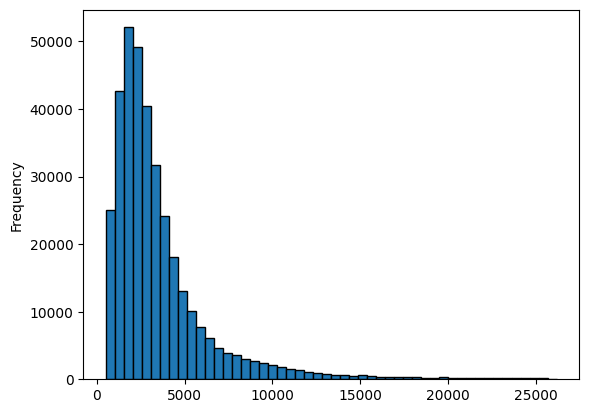

In [62]:
# Histogramme du prix au m²
df_eda["Valeur m2"].plot.hist(
    bins=50,
    edgecolor="black",
)

<Axes: >

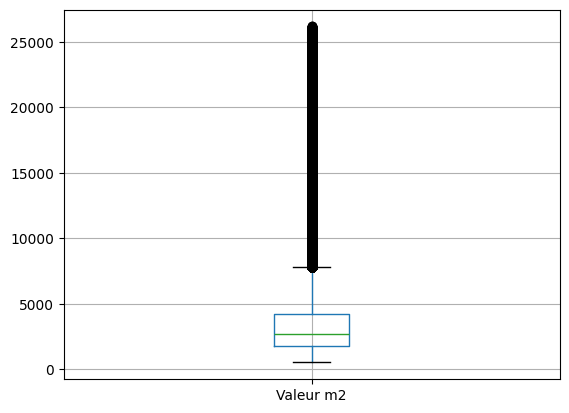

In [63]:
# Boxplot du prix au m²
df_eda.boxplot(column="Valeur m2")

> La présence de nombreux outliers à la hausse reflète la forte hétérogénéité du marché immobilier, avec des biens situés dans des zones très tendues ou atypiques.


### 2.3 Effets structurels du logement

#### Effet taille : relation entre surface et prix au mètre carré

Nous étudions maintenant la relation entre la surface réelle bâtie et le prix au mètre carré.

En immobilier, il est courant d’observer un **effet taille** :
à mesure que la surface augmente, le prix au m² tend à diminuer.


<Axes: xlabel='Surface reelle bati', ylabel='Valeur m2'>

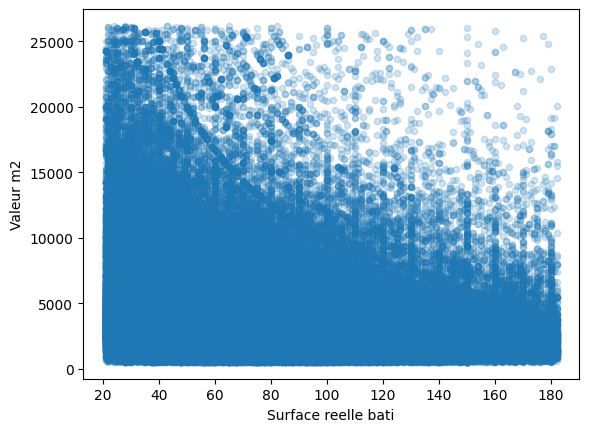

In [64]:
# Nuage de points : surface bâtie vs prix au m²
df_eda.plot.scatter(
    x="Surface reelle bati",
    y="Valeur m2",
    alpha=0.2
)


#### Comparaison maisons vs appartements

Nous comparons maintenant les prix au mètre carré entre maisons et appartements.
Ces deux types de biens obéissent à des logiques de marché différentes,
ce qui peut expliquer des niveaux de prix et des effets taille distincts.


<Axes: title={'center': 'Valeur m2'}, xlabel='Type local'>

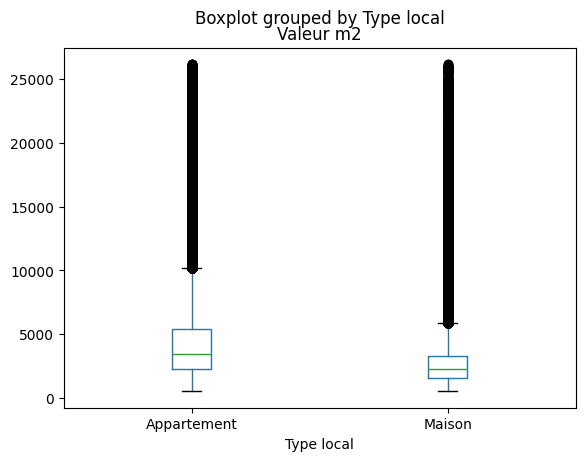

In [65]:
# Boxplot du prix au m² par type de bien
df_eda.boxplot(
    column="Valeur m2",
    by="Type local",
    grid=False
)

> Le boxplot montre une différence nette de niveau de prix entre appartements et maisons.
Les appartements présentent un prix au mètre carré médian plus élevé et une dispersion plus importante, ce qui reflète leur localisation plus fréquente en zones urbaines tendues.
Cette observation justifie l’intégration du type de bien comme variable explicative clé.

## 3. Modélisations sans localisation fine

### 3.1 Première régression linéaire

Nous estimons une régression linéaire afin d’expliquer le prix au mètre carré (*Valeur m2*)
à partir de caractéristiques intrinsèques du logement.

Variables explicatives retenues :
- la surface réelle bâtie (effet taille) ;
- le type de bien (maison ou appartement) ;
- le nombre de pièces principales.

Remarque : notre jeu de données ne couvre que l’année 2025, donc nous n’introduisons pas de variable temporelle.

In [66]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#### Préparation des données pour la régression

Nous créons une variable binaire pour représenter le type de bien :
- Appartement = 1
- Maison = 0

Nous sélectionnons ensuite les variables explicatives et la variable cible.
Enfin, nous supprimons les lignes avec valeurs manquantes pour éviter les erreurs lors de l’entraînement.

In [67]:
df_model = df.copy()

# Encodage du type de bien : 1 si appartement, 0 si maison
df_model["Appartement"] = (df_model["Type local"] == "Appartement").astype(int)

df_model_clean = df_model[["Surface reelle bati", "Appartement", "Nombre pieces principales","Valeur m2"]].dropna() # Suppression des lignes contenant au moins une valeur manquante
print(df_model.shape[0]-df_model_clean.shape[0])

X = df_model_clean[["Surface reelle bati", "Appartement", "Nombre pieces principales"]]
y = df_model_clean["Valeur m2"]

0


In [72]:
# Séparation train / test (80 % / 20 %), avec une graine fixe pour la reproductibilité
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

model = LinearRegression()

# Entraînement du modèle
model.fit(X_train1, y_train1)

# Prédictions sur les données de test
y_pred1 = model.predict(X_test1)

print(r2_score(y_test1, y_pred1))
print(mean_absolute_error(y_test1, y_pred1))


0.010396982394627385
19604.279882198996


On remarque que le modèle *naïf* de régression linéaire par rapport aux propriétés intrinsèques du logement est peu pertinent.

Pour que le résultat soit plus visuel :

In [69]:
coefficients = pd.Series(
    model.coef_,
    index=X.columns,
)
coefficients["Intercept"] = model.intercept_

print(coefficients)

Surface reelle bati           -14.21
Appartement                 18533.86
Nombre pieces principales   -1260.60
Intercept                   10491.71
dtype: float64


### 3.2 Spécification logarithmique

In [73]:
# Transformation logarithmique
X_log = X.copy()
X_log["Surface reelle bati"] = np.log(X_log["Surface reelle bati"])
y_log = np.log(y)

# On refait la même chose que tout à l'heure
X_train1_log, X_test1_log, y_train1_log, y_test1_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train1_log, y_train1_log)

print(r2_score(y_test1_log, model.predict(X_test1_log)))

0.09887892104850804


> En passant à une spécification logarithmique, le pouvoir explicatif du modèle augmente nettement.
Le R² atteint environ 10 %, ce qui confirme que les caractéristiques intrinsèques du logement expliquent une partie non négligeable du prix au mètre carré.
La part restante s’explique principalement par la localisation, que nous introduirons dans un second temps.

## 4. Introduction de la localisation

### 4.1 Localisation grossière : département

Avant d’introduire une localisation fine (coordonnées, distances), nous ajoutons
une variable géographique simple : le **département**.

Le département permet de capter des différences régionales de prix
(tension du marché, attractivité, niveau de vie),
tout en restant une information grossière et facile à interpréter.

Cette étape permet de mesurer l’apport de la localisation
par rapport à un modèle basé uniquement sur les caractéristiques du logement.


In [24]:
df_model_2 = df_model.copy()

df_model_2["Code departement"] = df_model_2["Code departement"].astype(str) # important pour traiter correctement des codes comme 01, 2A, 2B

In [38]:
# Création des variables indicatrices pour les départements 
departement_dummies = pd.get_dummies(
    df_model_2["Code departement"],
    prefix="Dep",
    drop_first=True
)
# Pour test : df_model_2.sample(n=5)

In [50]:
# On refait les mêmes manipulations

df_model_2_clean = df_model_2[["Surface reelle bati", "Appartement", "Nombre pieces principales","Valeur m2","Code departement"]].dropna()
print(df_model.shape[0]-df_model_clean.shape[0])

X_num = df_model_2[["Surface reelle bati", "Appartement", "Nombre pieces principales","Code departement"]]
X_num = pd.concat([X_num, departement_dummies], axis=1)
X_num = X_num.drop("Code departement",axis=1)
# X_num.sample(n=5)

X_num["Surface reelle bati"] = np.log(X_num["Surface reelle bati"])
y_num = np.log(df_model_2_clean["Valeur m2"])

0


In [75]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_num, y_num, test_size=0.2, random_state=42
)

model = LinearRegression()

model.fit(X_train2, y_train2)

print(r2_score(y_test2, model.predict(X_test2)))

0.26180538906087225


L’ajout du département améliore fortement le pouvoir explicatif du modèle ($R^2$ = 26%).
Cela confirme que la localisation explique une part majeure des différences
de prix au mètre carré.

Cette variable capte des effets régionaux (tension du marché, attractivité),
sans recourir à une localisation fine.

### 4.2 Variables départementales issues du scraping

Afin d’enrichir la base DVF avec des informations de contexte géographique,
nous construisons une base de données départementale à partir d’un **scraping de Wikipédia**.

L’objectif est de récupérer, pour chaque département français :
- le code INSEE ;
- le nom du département ;
- la préfecture ;
- la population ;
- la densité de population.

Ces variables permettent de capter des effets macro-géographiques
(niveau d’urbanisation, pression démographique),
sans recourir à une localisation fine.

Nous utilisons Wikipédia comme source car les informations sont publiques et structurées sous forme de tableaux.


In [ ]:
import requests
import io
import re

# 1. RÉCUPÉRATION DES DONNÉES

# URL de la page Wikipédia listant les départements français
url = "https://fr.wikipedia.org/wiki/Liste_des_d%C3%A9partements_fran%C3%A7ais"

# En-tête pour identifier proprement la requête HTTP
headers = {"User-Agent": "Etudiant_DataScience_Immo/1.0"}

# Requête HTTP vers Wikipédia
response = requests.get(url, headers=headers)

# Extraction des tableaux HTML contenant le mot "Densité"
# Cela permet d’identifier le tableau principal
dfs = pd.read_html(io.StringIO(response.text), match="Densité")

# Copie du premier tableau extrait
df_dept = dfs[0].copy()


# 2. SÉLECTION ET RENOMMAGE DES COLONNES UTILES

# On sélectionne manuellement les colonnes clés par leur position
# (les en-têtes Wikipédia pouvant changer selon les versions)
df_final = df_dept.iloc[:, [0, 1, 2, 11, 12]].copy()

# Renommage explicite des colonnes
df_final.columns = [
    'Code_Insee',
    'Département',
    'Préfecture',
    'Population_Dept',
    'Densité_Dept'
]


# 3. FONCTIONS DE NETTOYAGE

def clean_insee(code):
    # Nettoie et harmonise les codes département (01, 2A, 2B, 971, etc.)
    code = str(code).strip()
    if '2A' in code: return '2A'
    if '2B' in code: return '2B'
    digits = "".join(filter(str.isdigit, code))
    if digits.startswith('97'): return digits[:3]
    if len(digits) == 3: return digits[:2]
    return digits[:2].zfill(2)

def clean_numbers(val):
    # Convertit une valeur textuelle ("1 234 567[1]") en entier
    if pd.isna(val): return 0
    val = str(val)
    val = re.sub(r'\[.*?\]', '', val)        # supprime les références [1]
    val = val.replace('\xa0', '').replace(' ', '')
    val = val.split(',')[0]                  # ignore les décimales
    val = "".join(filter(str.isdigit, val))  # conserve uniquement les chiffres
    return int(val) if val else 0

def clean_text(text):
    # Nettoie les noms (département, préfecture)
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    return text.strip()


# 4. APPLICATION DU NETTOYAGE

df_final['Code_Insee'] = df_final['Code_Insee'].apply(clean_insee)
df_final['Population_Dept'] = df_final['Population_Dept'].apply(clean_numbers)
df_final['Densité_Dept'] = df_final['Densité_Dept'].apply(clean_numbers)
df_final['Département'] = df_final['Département'].apply(clean_text)
df_final['Préfecture'] = df_final['Préfecture'].apply(clean_text)

# Suppression des lignes parasites (ex. lignes de total national)
df_final = df_final[df_final['Code_Insee'] != '']

# Conversion finale de la population en entier
df_final['Population_Dept'] = (
    pd.to_numeric(
        df_final['Population_Dept'].astype(str)
        .str.replace(r'\D', '', regex=True)
        .str[:-4],
        errors='coerce'
    )
    .fillna(0)
    .astype(int)
)

# Vérification finale
print(df_final.head())
print(df_final.dtypes)


  Code_Insee              Département       Préfecture  Population_Dept  Densité_Dept
0         01                      Ain  Bourg-en-Bresse           671289          1165
1         02                    Aisne             Laon           525558           714
2         03                   Allier          Moulins           334715           456
3         04  Alpes-de-Haute-Provence  Digne-les-Bains           167179           241
4         05             Hautes-Alpes              Gap           141677           255
Code_Insee         object
Département        object
Préfecture         object
Population_Dept     int64
Densité_Dept        int64
dtype: object


#### Intégration des variables issues du scraping

Nous intégrons maintenant à la base DVF les variables départementales obtenues par scraping :
- la population du département ;
- la densité de population.

Ces variables permettent de capter des effets macro-géographiques
(niveau d’urbanisation, pression démographique).

In [24]:
# Copie du jeu de données DVF
df_model = df.copy()

# Harmonisation des types pour la clé de jointure
df_model["Code departement"] = df_model["Code departement"].astype(str)
df_final["Code_Insee"] = df_final["Code_Insee"].astype(str)

# Jointure avec les données issues du scraping
df_model = df_model.merge(
    df_final[["Code_Insee", "Population_Dept", "Densité_Dept"]],
    left_on="Code departement",
    right_on="Code_Insee",
    how="left"
)

# Vérification rapide des valeurs manquantes après jointure
df_model[["Population_Dept", "Densité_Dept"]].isna().mean()

Population_Dept    0.0
Densité_Dept       0.0
dtype: float64

Nous enrichissons la régression en ajoutant les variables départementales
de population et de densité.

Afin de conserver une spécification adaptée aux données immobilières,
nous utilisons une transformation logarithmique pour les variables continues.


In [25]:
# Encodage du type de bien
df_model["Appartement"] = (df_model["Type local"] == "Appartement").astype(int)

# Transformations logarithmiques
df_model["log_surface"] = np.log(df_model["Surface reelle bati"])
df_model["log_population"] = np.log(df_model["Population_Dept"])
df_model["log_densite"] = np.log(df_model["Densité_Dept"])

# Sélection des variables explicatives
X = df_model[
    ["log_surface", "Appartement", "Nombre pieces principales",
     "log_population", "log_densite"]
]

# Variable cible
y = np.log(df_model["Valeur m2"])

# Nettoyage des lignes incomplètes
df_model_clean = pd.concat([X, y], axis=1).dropna()
X = df_model_clean[X.columns]
y = df_model_clean[y.name]


Nous estimons une nouvelle régression linéaire incluant les variables
issues du scraping afin d’évaluer leur contribution explicative.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Évaluation du modèle
r2_scrap = r2_score(y_test, model.predict(X_test))
r2_scrap


0.1698245174435532

Le modèle utilisant les variables issues du scraping présente un R² inférieur à celui utilisant des indicatrices départementales.
Cela s’explique par le fait que les dummies départementales captent l’ensemble des effets spécifiques à chaque département, tandis que la population et la densité n’en captent qu’une partie structurelle.
En contrepartie, le modèle avec scraping est plus interprétable économiquement et permet de comprendre quels mécanismes sous-jacents expliquent les différences de prix.

In [27]:
# Affichage des coefficients estimés
pd.Series(
    model.coef_,
    index=X.columns
)


log_surface                 -0.458194
Appartement                  0.274866
Nombre pieces principales    0.042948
log_population               0.199361
log_densite                  0.165744
dtype: float64

La régression estimée est de type log–log, ce qui permet d’interpréter les coefficients
comme des effets proportionnels, toutes choses égales par ailleurs.

Le coefficient associé à la surface réelle bâtie est égal à **−0,458**.
Cela signifie qu’une augmentation de 10 % de la surface d’un logement
est associée à une baisse d’environ **4,6 %** du prix au mètre carré.
Ce résultat met en évidence un effet taille marqué,
traduisant des rendements décroissants de la surface,
phénomène classique sur le marché immobilier résidentiel.

Le coefficient de la variable indiquant un appartement est égal à **0,275**.
À caractéristiques identiques, un appartement présente donc un prix au mètre carré
environ **27 % plus élevé** qu’une maison.
Cet effet reflète des différences structurelles de marché,
les appartements étant plus fréquemment situés dans des zones urbaines denses et tendues.

Le nombre de pièces principales a un coefficient égal à **0,043**.
À surface donnée, une pièce supplémentaire est associée
à une hausse d’environ **4 %** du prix au mètre carré,
ce qui suggère qu’un logement mieux découpé ou plus fonctionnel
est davantage valorisé.

Le coefficient associé à la population départementale est égal à **0,199**.
Une augmentation de 10 % de la population d’un département
est donc associée à une hausse d’environ **2 %** du prix au mètre carré.
Cette variable capte un effet de pression démographique et d’attractivité territoriale.

Enfin, le coefficient de la densité de population est égal à **0,166**.
Une augmentation de 10 % de la densité départementale
est associée à une hausse d’environ **1,7 %** du prix au mètre carré,
confirmant le rôle de l’urbanisation et de la rareté du foncier
dans la formation des prix immobiliers.

In [28]:
df_model

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Valeur m2,Code_Insee,Population_Dept,Densité_Dept,Appartement,log_surface,log_population,log_densite
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-01-07,Vente,468000.0,454,NaN,RUE,0090,DE LA REPUBLIQUE,1550,FARGES,01,158,NaN,B,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,NaN,111.0,5.0,S,NaN,133.0,4216.216216,01,671289,1165,0,4.709530,13.416955,7.060476
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-01-06,Vente,180000.0,66,NaN,RUE,0050,DE LA FRUITIERE,1200,MONTANGES,01,257,NaN,AC,341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,NaN,87.0,4.0,S,NaN,76.0,2068.965517,01,671289,1165,1,4.465908,13.416955,7.060476
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-01-06,Vente,490000.0,459,B,CHE,0356,DU PETIT CORGENON,1310,BUELLAS,01,65,NaN,B,1705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,NaN,190.0,6.0,S,NaN,500.0,2578.947368,01,671289,1165,0,5.247024,13.416955,7.060476
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-01-06,Vente,490000.0,459,B,CHE,0356,DU PETIT CORGENON,1310,BUELLAS,01,65,NaN,B,1705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,NaN,190.0,6.0,AG,NaN,2452.0,2578.947368,01,671289,1165,0,5.247024,13.416955,7.060476
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-01-09,Vente,183000.0,250,NaN,AV,0041,DE BELLE FERME,1170,GEX,01,173,NaN,AH,194,NaN,218,"35,74",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,35.0,2.0,NaN,NaN,NaN,5228.571429,01,671289,1165,1,3.555348,13.416955,7.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-06-23,Vente,835000.0,167,NaN,RUE,8699,SAINT MAUR,75011,PARIS 11,75,111,NaN,AC,71,NaN,207,NaN,211,"91,08",NaN,NaN,NaN,NaN,NaN,NaN,2,2,Appartement,NaN,70.0,4.0,NaN,NaN,NaN,11928.571429,75,2113705,20054,1,4.248495,14.563953,9.906184
403461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-06-25,Vente,375000.0,4,B,RUE,3479,FABRE D EGLANTINE,75012,PARIS 12,75,112,NaN,CM,28,NaN,281,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,Appartement,NaN,33.0,1.0,NaN,NaN,NaN,11363.636364,75,2113705,20054,1,3.496508,14.563953,9.906184
403462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-06-25,Vente,1370000.0,2,NaN,AV,7149,PAUL DOUMER,75016,PARIS 16,75,116,NaN,DS,9,NaN,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,92.0,2.0,NaN,NaN,NaN,14891.304348,75,2113705,20054,1,4.521789,14.563953,9.906184
403463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000001,2025-06-27,Vente,550000.0,84,NaN,RUE,9679,VERGNIAUD,75013,PARIS 13,75,113,NaN,DK,8,NaN,376,NaN,421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,Appartement,NaN,61.0,3.0,NaN,NaN,NaN,9016.393443,75,2113705,20054,1,4.110874,14.563953,9.906184


## 5. Localisation fine et modèles avancés


### 5.1 Intégration des gares SNCF

Nous intégrons les gares SNCF afin d’introduire une information de localisation
liée à l’accessibilité ferroviaire.

Les données utilisées proviennent du jeu de données officiel des gares SNCF,
au format CSV.
Dans un premier temps, nous construisons une variable simple indiquant
si une gare est présente dans la commune du logement.

In [29]:
# Chargement du fichier des gares SNCF
gares = pd.read_csv(
    "/home/onyxia/work/Projet-Python-2A-ENSAE/gares-de-voyageurs.csv",
    sep=";"
)

# Vérification des colonnes disponibles
gares.columns


Index(['Nom', 'Trigramme', 'Segment(s) DRG', 'Position géographique', 'Code commune', 'Code(s) UIC'], dtype='object')

In [30]:
# Liste des codes communes disposant d'au moins une gare SNCF
communes_avec_gare = gares["Code commune"].astype(str).unique()

# Vérification rapide
len(communes_avec_gare)

2473

### 5.2 Construction d’une variable d’accessibilité ferroviaire

En l’absence de coordonnées géographiques précises pour les logements,
nous utilisons l’échelle communale pour mesurer l’accessibilité ferroviaire.

Nous construisons une variable binaire indiquant
si la commune du logement dispose d’au moins une gare SNCF.

Avant de pouvoir intégrer les gares SNCF à la base DVF, il est nécessaire
d’harmoniser les identifiants géographiques.

Dans la base DVF, la variable *Code commune* correspond uniquement
au code communal à l’intérieur du département,
tandis que la base des gares SNCF utilise le **code INSEE complet**
(association du code département et du code commune).

Nous reconstruisons donc, côté DVF, un **code commune au format INSEE à 5 chiffres**,
en combinant le code département et le code commune,
afin de rendre les deux bases homogènes et permettre une jointure correcte.

In [31]:
# Harmonisation des clés
df_model["Code departement"] = df_model["Code departement"].astype(str)
df_final["Code_Insee"] = df_final["Code_Insee"].astype(str)

# Jointure des variables issues du scraping
df_model = df_model.merge(
    df_final[["Code_Insee", "Population_Dept", "Densité_Dept"]],
    left_on="Code departement",
    right_on="Code_Insee",
    how="left"
)

# Vérification immédiate
df_model[["Population_Dept", "Densité_Dept"]].head()

KeyError: "None of [Index(['Population_Dept', 'Densité_Dept'], dtype='object')] are in the [columns]"

In [ ]:
# Harmonisation du code département (2 chiffres, avec zéros)
df_model["Code_Insee"] = (
    df_model["Code_Insee"]
    .astype(str)
    .str.zfill(2)
)

# Harmonisation du code commune DVF (3 chiffres, avec zéros)
df_model["Code commune"] = (
    df_model["Code commune"]
    .astype(str)
    .str.zfill(3)
)

# Reconstruction du code INSEE complet (5 chiffres)
df_model["Code_INSEE"] = df_model["Code departement"] + df_model["Code commune"]

# Vérification
df_model["Code_INSEE"].head()

In [ ]:
# Création de la variable binaire d’accessibilité ferroviaire
df_final["gare_commune"] = (
    df_final["Code_INSEE"].astype(str)
    .isin(communes_avec_gare)
    .astype(int)
)

# Vérification de la distribution
df_final["gare_commune"].value_counts(normalize=True)

### 5.3 Intégration de l’accessibilité ferroviaire dans le modèle

Nous ajoutons la variable `gare_commune` au modèle log–log afin de mesurer
l’apport marginal de l’accessibilité ferroviaire,
toutes choses égales par ailleurs.

In [ ]:
df_model.columns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



# Encodage du type de bien
df_model["Appartement"] = (df_model["Type local"] == "Appartement").astype(int)

# Transformations logarithmiques
df_model["log_surface"] = np.log(df_model["Surface reelle bati"])
df_model["log_population"] = np.log(df_model["Population_Dept"])
df_model["log_densite"] = np.log(df_model["Densité_Dept"])

# Variables explicatives (ajout de gare_commune)
X = df_model[
    [
        "log_surface",
        "Appartement",
        "Nombre pieces principales",
        "log_population",
        "log_densite",
        "gare_commune"
    ]
]

# Variable cible (log)
y = np.log(df_model["Valeur m2"])

# Nettoyage des lignes incomplètes
df_model_clean = pd.concat([X, y], axis=1).dropna()
X = df_model_clean[X.columns]
y = df_model_clean[y.name]

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Évaluation
r2_gare = r2_score(y_test, model.predict(X_test))
r2_gare


In [ ]:
df_model

### 5.2 Modèle non linéaire : Random Forest

Nous utilisons une Random Forest afin de capturer automatiquement
les non-linéarités et interactions complexes entre variables.

Ce modèle sert de benchmark prédictif.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

r2_rf = r2_score(y_test, rf.predict(X_test))
r2_rf

Le modèle Random Forest présente un coefficient de détermination d’environ **40 %**, supérieur à celui des modèles linéaires testés précédemment.

Cette amélioration s’explique par la capacité de la Random Forest à capturer automatiquement
des **relations non linéaires** et des **interactions complexes** entre les variables explicatives,
sans avoir à les spécifier explicitement.
Contrairement à la régression linéaire, le modèle n’impose pas de forme fonctionnelle
a priori entre les variables et le prix au mètre carré.

Ce résultat met en évidence l’existence de mécanismes non linéaires dans la formation des prix immobiliers,
en particulier dans l’interaction entre les caractéristiques intrinsèques du logement
(surface, nombre de pièces, type de bien) et les variables macro-géographiques
(population et densité départementales).

En contrepartie, la Random Forest est moins interprétable que les modèles linéaires :
elle permet d’améliorer la performance prédictive,
mais au prix d’une lecture économique plus limitée des effets marginaux.
Nous utilisons donc ce modèle comme **benchmark prédictif**,
tandis que les modèles linéaires restent privilégiés pour l’interprétation économique.

## 6. Conclusion et perspectives